In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import seaborn as sns
import matplotlib.colors as mcolors
import glob
import os
import xarray as xr
import datetime
from salishsea_tools import viz_tools, tidetools, geo_tools, gsw_calls, wind_tools
import pickle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import h5py
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [25]:
def make_list_of_halocline(nemo_y, nemo_x, tfiles, cfiles):

    ts_y = nemo_y
    ts_x = nemo_x

    list_of_haloclines = np.array([])

    for tfile0, cfile0 in zip(tfiles, cfiles):

        cfile = nc.Dataset(cfile0)
        tfile = nc.Dataset(tfile0)
        dv = tfile['deptht'][:]

        for t in range(24):

            delt_z = cfile['e3t'][t,:,ts_y,ts_x]
            #remove the stupid singletons
            delt_z = np.squeeze(delt_z)

            sv = tfile['vosaline'][t,:,ts_y,ts_x]
            sv = np.squeeze(sv)

            #for this grid cell, where do we no longer have salinity values?
            bottom = np.where(sv ==0)

            fxnl_sal = sv[0:bottom[0][0]]
            fxnl_e3t = delt_z[0:bottom[0][0]]
            fxnl_depth = dv[0:bottom[0][0]]

            sal_gradient = np.zeros_like(fxnl_depth)

            #calculating gradient
            for i in range(1,bottom[0][0]):
                sal_gradient[i] = (fxnl_sal[i]-fxnl_sal[i-1])/fxnl_e3t[i]

            mg = max(sal_gradient)

            halocline = np.where(sal_gradient == mg)
            halocline = np.squeeze(halocline)
            halocline = fxnl_depth[halocline]

            list_of_haloclines = np.append(list_of_haloclines, halocline)
    return list_of_haloclines

In [4]:
SOG350high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SOG/Lagrangian_AKNS_crude_fakewinds_04may16.nc', 'r')
SOG350low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SOG/Lagrangian_AKNS_crude_fakewinds_05aug17.nc', 'r')
SOG150high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SOG/Lagrangian_AKNS_crude_fakewinds_11may17.nc', 'r')
SOG150low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SOG/Lagrangian_AKNS_crude_fakewinds_13nov17.nc', 'r')

In [5]:
SOG350hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_01may16/04jan20-11jan20/t.hdf5', 'r')
SOG350lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_02aug17/04jan20-11jan20/t.hdf5', 'r')
SOG150hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_08may17/04jan20-11jan20/t.hdf5', 'r')
SOG150lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_10nov17/04jan20-11jan20/t.hdf5', 'r')

In [6]:
TP350high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/TP/Lagrangian_AKNS_crude_fakewinds_TP_20nov17.nc', 'r')
TP350low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/TP/Lagrangian_AKNS_crude_fakewinds_TP_31may18.nc', 'r')
TP150high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/TP/Lagrangian_AKNS_crude_fakewinds_TP_17nov15.nc', 'r')
TP150low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/TP/Lagrangian_AKNS_crude_fakewinds_TP_13oct18.nc', 'r')

In [7]:
TP350hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_20nov17/04jan20-11jan20/t.hdf5', 'r')
TP350lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_31may18/04jan20-11jan20/t.hdf5', 'r')
TP150hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_17nov15/04jan20-11jan20/t.hdf5', 'r')
TP150lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_13oct18/04jan20-11jan20/t.hdf5', 'r')

In [8]:
SB350high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SB/Lagrangian_AKNS_crude_fakewinds_SB_26dec16.nc', 'r')
SB350low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SB/Lagrangian_AKNS_crude_fakewinds_SB_13oct18.nc', 'r')
SB150high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SB/Lagrangian_AKNS_crude_fakewinds_SB_26jun16.nc', 'r')
SB150low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SB/Lagrangian_AKNS_crude_fakewinds_SB_02aug18.nc', 'r')

In [9]:
SB350hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SB/fakewinds_26dec16/04jan20-11jan20/t.hdf5', 'r')
## reusing TP forcing files because for wind event
SB350lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_13oct18/04jan20-11jan20/t.hdf5', 'r')
SB150hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SB/fakewinds_26jun16/04jan20-11jan20/t.hdf5', 'r')
SB150lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SB/fakewinds_02aug18/04jan20-11jan20/t.hdf5', 'r')

In [10]:
BP350high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/BP/Lagrangian_AKNS_crude_fakewinds_BP_01may16.nc', 'r')
BP350low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/BP/Lagrangian_AKNS_crude_fakewinds_BP_13oct18.nc', 'r')
BP150high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/BP/Lagrangian_AKNS_crude_fakewinds_BP_20nov17.nc', 'r')
BP150low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/BP/Lagrangian_AKNS_crude_fakewinds_BP_19jul15.nc', 'r')

In [11]:
## reusing TP and SOG forcing files because for wind events
BP350hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_01may16/04jan20-11jan20/t.hdf5', 'r')
BP350lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_13oct18/04jan20-11jan20/t.hdf5', 'r')
BP150hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_20nov17/04jan20-11jan20/t.hdf5', 'r')
BP150lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/BP/fakewinds_19jul15/04jan20-11jan20/t.hdf5', 'r')

In [12]:
SOGzero = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/zerowinds/Lagrangian_AKNS_crude_fakewinds_zerowinds_SOG.nc')
TPzero = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/zerowinds/Lagrangian_AKNS_crude_fakewinds_zerowinds_TP.nc')
SBzero = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/zerowinds/Lagrangian_AKNS_crude_fakewinds_zerowinds_SB.nc')
BPzero = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/zerowinds/Lagrangian_AKNS_crude_fakewinds_zerowinds_BP.nc')

In [13]:
zerot = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/zero_winds/04jan20-11jan20/t.hdf5')

In [14]:
SOG350highsal = np.array([])
SOG350lowsal = np.array([])
SOG150highsal = np.array([])
SOG150lowsal = np.array([])
SOGzerosal = np.array([])

TP350highsal = np.array([])
TP350lowsal = np.array([])
TP150highsal = np.array([])
TP150lowsal = np.array([])
TPzerosal = np.array([])

SB350highsal = np.array([])
SB350lowsal = np.array([])
SB150highsal = np.array([])
SB150lowsal = np.array([])
SBzerosal = np.array([])

BP350highsal = np.array([])
BP350lowsal = np.array([])
BP150highsal = np.array([])
BP150lowsal = np.array([])
BPzerosal = np.array([])

for hr in range(1,168):
        
    SOG350highmask = np.ma.masked_equal(SOG350high['Thickness_2D'][hr,:].T, 0).mask
    SOG350highsal = np.append(SOG350highsal, 
                              np.ma.mean(np.ma.masked_array(SOG350hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SOG350highmask)))
    
    SOG350lowmask = np.ma.masked_equal(SOG350low['Thickness_2D'][hr,:].T, 0).mask
    SOG350lowsal = np.append(SOG350lowsal, 
                              np.ma.mean(np.ma.masked_array(SOG350lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SOG350lowmask)))
    
    SOG150highmask = np.ma.masked_equal(SOG150high['Thickness_2D'][hr,:].T, 0).mask
    SOG150highsal = np.append(SOG150highsal, 
                              np.ma.mean(np.ma.masked_array(SOG150hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SOG150highmask)))
    
    SOG150lowmask = np.ma.masked_equal(SOG150low['Thickness_2D'][hr,:].T, 0).mask
    SOG150lowsal = np.append(SOG150lowsal, 
                              np.ma.mean(np.ma.masked_array(SOG150lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SOG150lowmask)))
    SOGzeromask = np.ma.masked_equal(SOGzero['Thickness_2D'][hr,:].T, 0).mask
    SOGzerosal = np.append(SOGzerosal, 
                              np.ma.mean(np.ma.masked_array(zerot['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SOGzeromask)))
    
    TP350highmask = np.ma.masked_equal(TP350high['Thickness_2D'][hr,:].T, 0).mask
    TP350highsal = np.append(TP350highsal, 
                              np.ma.mean(np.ma.masked_array(TP350hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = TP350highmask)))
    
    TP350lowmask = np.ma.masked_equal(TP350low['Thickness_2D'][hr,:].T, 0).mask
    TP350lowsal = np.append(TP350lowsal, 
                              np.ma.mean(np.ma.masked_array(TP350lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = TP350lowmask)))
    
    TP150highmask = np.ma.masked_equal(TP150high['Thickness_2D'][hr,:].T, 0).mask
    TP150highsal = np.append(TP150highsal, 
                              np.ma.mean(np.ma.masked_array(TP150hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = TP150highmask)))
    
    TP150lowmask = np.ma.masked_equal(TP150low['Thickness_2D'][hr,:].T, 0).mask
    TP150lowsal = np.append(TP150lowsal, 
                              np.ma.mean(np.ma.masked_array(TP150lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = TP150lowmask)))
    TPzeromask = np.ma.masked_equal(TPzero['Thickness_2D'][hr,:].T, 0).mask
    TPzerosal = np.append(TPzerosal, 
                              np.ma.mean(np.ma.masked_array(zerot['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = TPzeromask)))
    
    SB350highmask = np.ma.masked_equal(SB350high['Thickness_2D'][hr,:].T, 0).mask
    SB350highsal = np.append(SB350highsal, 
                              np.ma.mean(np.ma.masked_array(SB350hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SB350highmask)))
    
    SB350lowmask = np.ma.masked_equal(SB350low['Thickness_2D'][hr,:].T, 0).mask
    SB350lowsal = np.append(SB350lowsal, 
                              np.ma.mean(np.ma.masked_array(SB350lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SB350lowmask)))
    
    SB150highmask = np.ma.masked_equal(SB150high['Thickness_2D'][hr,:].T, 0).mask
    SB150highsal = np.append(SB150highsal, 
                              np.ma.mean(np.ma.masked_array(SB150hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SB150highmask)))
    
    SB150lowmask = np.ma.masked_equal(SB150low['Thickness_2D'][hr,:].T, 0).mask
    SB150lowsal = np.append(SB150lowsal, 
                              np.ma.mean(np.ma.masked_array(SB150lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SB150lowmask)))
    
    SBzeromask = np.ma.masked_equal(SBzero['Thickness_2D'][hr,:].T, 0).mask
    SBzerosal = np.append(SBzerosal, 
                              np.ma.mean(np.ma.masked_array(zerot['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SBzeromask)))
    
    BP350highmask = np.ma.masked_equal(BP350high['Thickness_2D'][hr,:].T, 0).mask
    BP350highsal = np.append(BP350highsal, 
                              np.ma.mean(np.ma.masked_array(BP350hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = BP350highmask)))
    
    BP350lowmask = np.ma.masked_equal(BP350low['Thickness_2D'][hr,:].T, 0).mask
    BP350lowsal = np.append(BP350lowsal, 
                              np.ma.mean(np.ma.masked_array(BP350lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = BP350lowmask)))
    
    BP150highmask = np.ma.masked_equal(BP150high['Thickness_2D'][hr,:].T, 0).mask
    BP150highsal = np.append(BP150highsal, 
                              np.ma.mean(np.ma.masked_array(BP150hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = BP150highmask)))
    
    BP150lowmask = np.ma.masked_equal(BP150low['Thickness_2D'][hr,:].T, 0).mask
    BP150lowsal = np.append(BP150lowsal, 
                              np.ma.mean(np.ma.masked_array(BP150lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = BP150lowmask)))
    
    BPzeromask = np.ma.masked_equal(BPzero['Thickness_2D'][hr,:].T, 0).mask
    BPzerosal = np.append(BPzerosal, 
                              np.ma.mean(np.ma.masked_array(zerot['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = BPzeromask)))

In [15]:
SOGs0 = np.array([])
SOGs1 = np.array([])
SOGs2 = np.array([])
SOGs3 = np.array([])
SOGs4 = np.array([])

for key in list(SOG350hight['Results']['salinity'].keys()):
    SOGs0 = np.append(SOGs0, SOG350hight['Results']['salinity'][key][-1, 251, 473])
    SOGs1 = np.append(SOGs1, SOG350lowt['Results']['salinity'][key][-1, 251, 473])
    SOGs2 = np.append(SOGs2, SOG150hight['Results']['salinity'][key][-1, 251, 473])
    SOGs3 = np.append(SOGs3, SOG150lowt['Results']['salinity'][key][-1, 251, 473])
    SOGs4 = np.append(SOGs4, zerot['Results']['salinity'][key][-1, 251, 473])

In [16]:
SOGd0 = np.array([])
SOGd1 = np.array([])
SOGd2 = np.array([])
SOGd3 = np.array([])
SOGd4 = np.array([])

for key in list(SOG350hight['Results']['Diffusivity'].keys()):
    SOGd0 = np.append(SOGd0, SOG350hight['Results']['Diffusivity'][key][-2, 251, 473])
    SOGd1 = np.append(SOGd1, SOG350lowt['Results']['Diffusivity'][key][-2, 251, 473])
    SOGd2 = np.append(SOGd2, SOG150hight['Results']['Diffusivity'][key][-2, 251, 473])
    SOGd3 = np.append(SOGd3, SOG150lowt['Results']['Diffusivity'][key][-2, 251, 473])
    SOGd4 = np.append(SOGd4, zerot['Results']['Diffusivity'][key][-2, 251, 473])

In [29]:
SOGh0 = make_list_of_halocline(474, 252, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_01may16/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_01may16/*/*SalishSea*carp_T*'))[3:-1])
SOGh1 = make_list_of_halocline(474, 252, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_02aug17/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_02aug17/*/*SalishSea*carp_T*'))[3:-1])
SOGh2 = make_list_of_halocline(474, 252, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_08may17/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_08may17/*/*SalishSea*carp_T*'))[3:-1])
SOGh3 = make_list_of_halocline(474, 252, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_10nov17/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_10nov17/*/*SalishSea*carp_T*'))[3:-1])
SOGh4 = make_list_of_halocline(474, 252, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/zero_winds/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/zero_winds/*/*SalishSea*carp_T*'))[3:-1])

# SOG

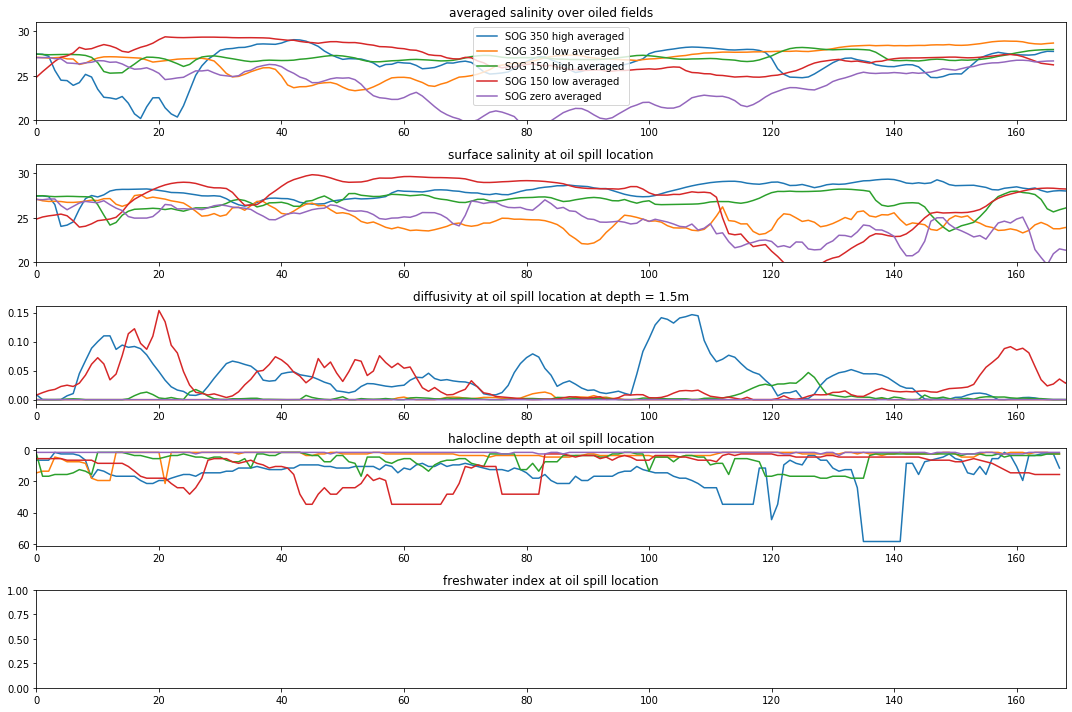

In [31]:
fig, ax = plt.subplots(5, 1, figsize = (15,10))
ax[0].plot(SOG350highsal, label = 'SOG 350 high averaged')
ax[0].plot(SOG350lowsal, label = 'SOG 350 low averaged')
ax[0].plot(SOG150highsal, label = 'SOG 150 high averaged')
ax[0].plot(SOG150lowsal, label = 'SOG 150 low averaged')
ax[0].plot(SOGzerosal, label = 'SOG zero averaged')
ax[0].legend()
ax[0].set_title('averaged salinity over oiled fields')
ax[0].set_ylim(20,31);

ax[1].plot(SOGs0, label = 'SOG 350 high')
ax[1].plot(SOGs1,label = 'SOG 350 low')
ax[1].plot(SOGs2,  label = 'SOG 150 high')
ax[1].plot(SOGs3, label = 'SOG 150 low')
ax[1].plot(SOGs4, label = 'SOG zero')
ax[1].set_title('surface salinity at oil spill location')
ax[1].set_ylim(20,31);

ax[2].plot(SOGd0, label = 'SOG 350 high')
ax[2].plot(SOGd1,label = 'SOG 350 low')
ax[2].plot(SOGd2,  label = 'SOG 150 high')
ax[2].plot(SOGd3, label = 'SOG 150 low')
ax[2].plot(SOGd4, label = 'SOG zero')
ax[2].set_title('diffusivity at oil spill location at depth = 1.5m')

ax[3].plot(SOGh0)
ax[3].plot(SOGh1)
ax[3].plot(SOGh2)
ax[3].plot(SOGh3)
ax[3].plot(SOGh4)
ax[3].invert_yaxis()
ax[3].set_title('halocline depth at oil spill location')

ax[4].set_title('freshwater index at oil spill location')

for a in ax:
    a.set_xlim(0,168)
plt.tight_layout()

# Turn Point

In [18]:
TPs0 = np.array([])
TPs1 = np.array([])
TPs2 = np.array([])
TPs3 = np.array([])
TPs4 = np.array([])

for key in list(SOG350hight['Results']['salinity'].keys()):
    TPs0 = np.append(TPs0, TP350hight['Results']['salinity'][key][-1, 249, 342])
    TPs1 = np.append(TPs1, TP350lowt['Results']['salinity'][key][-1, 249, 342])
    TPs2 = np.append(TPs2, TP150hight['Results']['salinity'][key][-1, 249, 342])
    TPs3 = np.append(TPs3, TP150lowt['Results']['salinity'][key][-1, 249, 342])
    TPs3 = np.append(TPs3, zerot['Results']['salinity'][key][-1, 249, 342])

In [19]:
TPd0 = np.array([])
TPd1 = np.array([])
TPd2 = np.array([])
TPd3 = np.array([])
TPd4 = np.array([])

for key in list(SOG350hight['Results']['Diffusivity'].keys()):
    TPd0 = np.append(TPd0, TP350hight['Results']['Diffusivity'][key][-2, 249, 342])
    TPd1 = np.append(TPd1, TP350lowt['Results']['Diffusivity'][key][-2, 249, 342])
    TPd2 = np.append(TPd2, TP150hight['Results']['Diffusivity'][key][-2, 249, 342])
    TPd3 = np.append(TPd3, TP150lowt['Results']['Diffusivity'][key][-2, 249, 342])
    TPd4 = np.append(TPd4, zerot['Results']['Diffusivity'][key][-2, 249, 342])

In [32]:
TPh0 = make_list_of_halocline(343, 250, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/20nov17/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/20nov17/*/*SalishSea*carp_T*'))[3:-1])
TPh1 = make_list_of_halocline(343, 250, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/31may18/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/31may18/*/*SalishSea*carp_T*'))[3:-1])
TPh2 = make_list_of_halocline(343, 250, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/17nov15/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/17nov15/*/*SalishSea*carp_T*'))[3:-1])
TPh3 = make_list_of_halocline(343, 250, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/13oct18/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/13oct18/*/*SalishSea*carp_T*'))[3:-1])
TPh4 = make_list_of_halocline(343, 250, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/zero_winds/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/zero_winds/*/*SalishSea*carp_T*'))[3:-1])

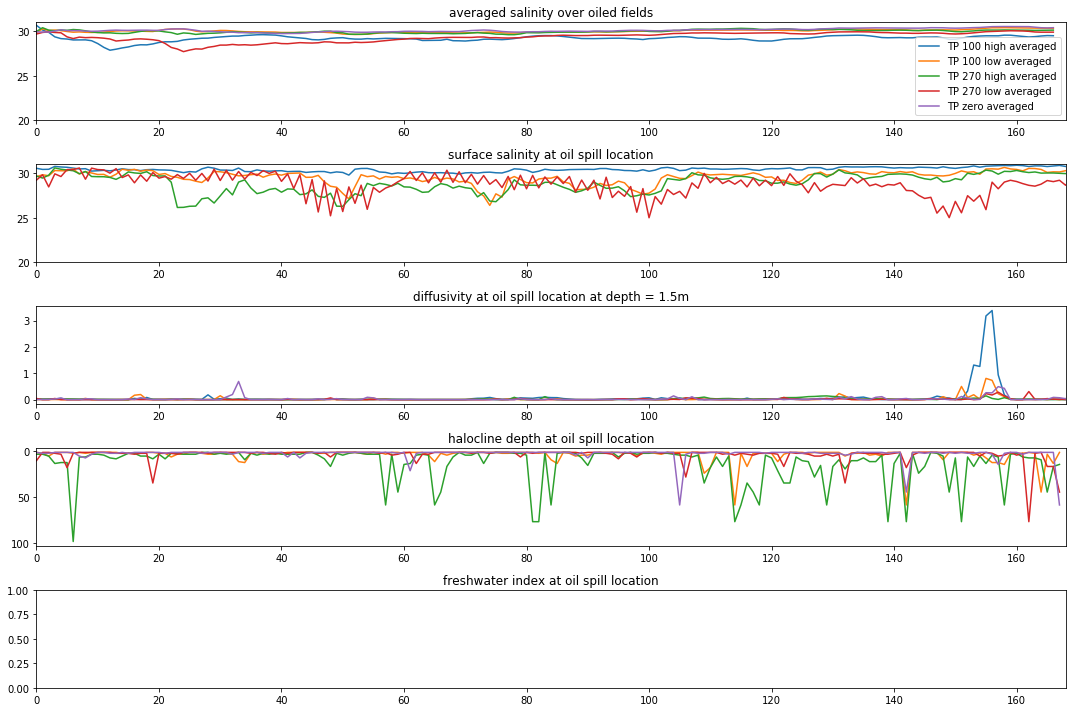

In [33]:
fig, ax = plt.subplots(5, 1, figsize = (15,10))
ax[0].plot(TP350highsal, label = 'TP 100 high averaged')
ax[0].plot(TP350lowsal, label = 'TP 100 low averaged')
ax[0].plot(TP150highsal, label = 'TP 270 high averaged')
ax[0].plot(TP150lowsal, label = 'TP 270 low averaged')
ax[0].plot(TPzerosal, label = 'TP zero averaged')
ax[0].legend()
ax[0].set_title('averaged salinity over oiled fields')
ax[0].set_ylim(20,31);

ax[1].plot(TPs0, label = 'SOG 350 high')
ax[1].plot(TPs1,label = 'SOG 350 low')
ax[1].plot(TPs2,  label = 'SOG 150 high')
ax[1].plot(TPs3, label = 'SOG 150 low')
ax[1].plot(TPs4, label = 'SOG zero')
ax[1].set_title('surface salinity at oil spill location')
ax[1].set_ylim(20,31);

ax[2].plot(TPd0, label = 'SOG 350 high')
ax[2].plot(TPd1,label = 'SOG 350 low')
ax[2].plot(TPd2,  label = 'SOG 150 high')
ax[2].plot(TPd3, label = 'SOG 150 low')
ax[2].plot(TPd4, label = 'SOG zero')
ax[2].set_title('diffusivity at oil spill location at depth = 1.5m')

ax[3].plot(TPh0)
ax[3].plot(TPh1)
ax[3].plot(TPh2)
ax[3].plot(TPh3)
ax[3].plot(TPh4)
ax[3].invert_yaxis()
ax[3].set_title('halocline depth at oil spill location')

ax[4].set_title('freshwater index at oil spill location')

for a in ax:
    a.set_xlim(0,168)
plt.tight_layout()

# Salmon Bank

In [21]:
SBs0 = np.array([])
SBs1 = np.array([])
SBs2 = np.array([])
SBs3 = np.array([])
SBs4 = np.array([])

for key in list(SOG350hight['Results']['salinity'].keys()):
    SBs0 = np.append(SBs0, SB350hight['Results']['salinity'][key][-1, 266, 255])
    SBs1 = np.append(SBs1, SB350lowt['Results']['salinity'][key][-1, 266, 255])
    SBs2 = np.append(SBs2, SB150hight['Results']['salinity'][key][-1, 266, 255])
    SBs3 = np.append(SBs3, SB150lowt['Results']['salinity'][key][-1, 266, 255])
    SBs3 = np.append(SBs3, zerot['Results']['salinity'][key][-1, 266, 255])
    
SBd0 = np.array([])
SBd1 = np.array([])
SBd2 = np.array([])
SBd3 = np.array([])
SBd4 = np.array([])

for key in list(SOG350hight['Results']['Diffusivity'].keys()):
    SBd0 = np.append(SBd0, SB350hight['Results']['Diffusivity'][key][-2, 266, 255])
    SBd1 = np.append(SBd1, SB350lowt['Results']['Diffusivity'][key][-2, 266, 255])
    SBd2 = np.append(SBd2, SB150hight['Results']['Diffusivity'][key][-2, 266, 255])
    SBd3 = np.append(SBd3, SB150lowt['Results']['Diffusivity'][key][-2, 266, 255])
    SBd4 = np.append(SBd4, zerot['Results']['Diffusivity'][key][-2, 266, 255])

In [34]:
SBh0 = make_list_of_halocline(267, 256, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SB/26dec16/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SB/26dec16/*/*SalishSea*carp_T*'))[3:-1])
SBh1 = make_list_of_halocline(267, 256, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/13oct18/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/13oct18/*/*SalishSea*carp_T*'))[3:-1])
SBh2 = make_list_of_halocline(267, 256, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SB/26jun16/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SB/26jun16/*/*SalishSea*carp_T*'))[3:-1])
SBh3 = make_list_of_halocline(267, 256, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SB/02aug18/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SB/02aug18/*/*SalishSea*carp_T*'))[3:-1])
SBh4 = make_list_of_halocline(267, 256, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/zero_winds/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/zero_winds/*/*SalishSea*carp_T*'))[3:-1])

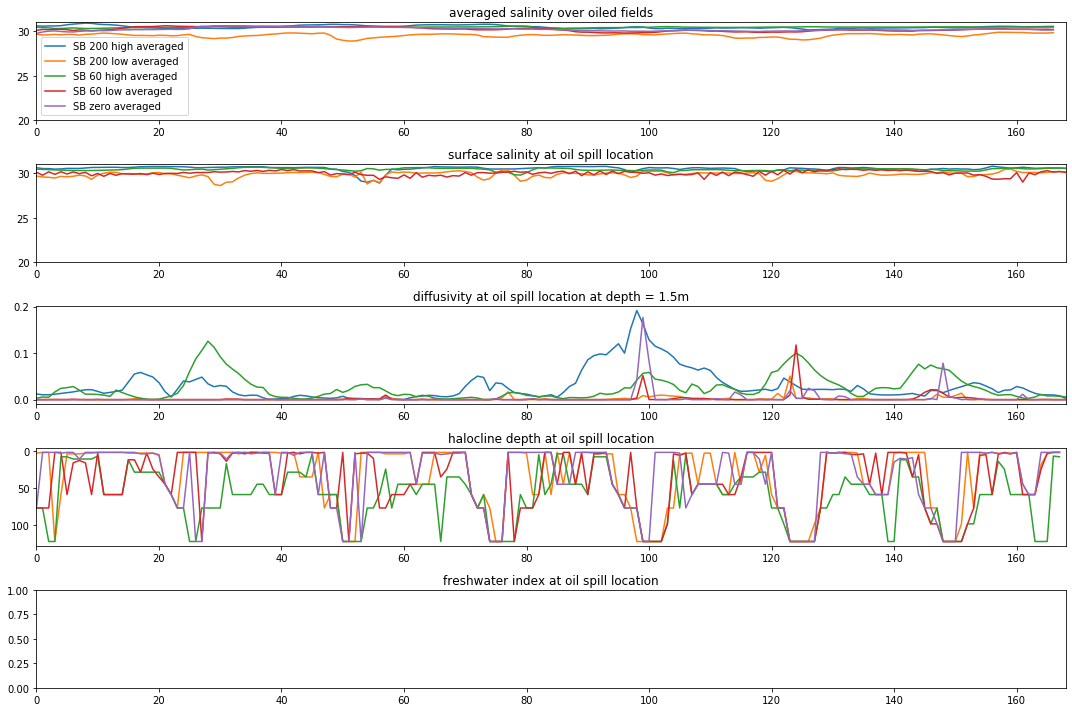

In [35]:
fig, ax = plt.subplots(5, 1, figsize = (15,10))
ax[0].plot(SB350highsal, label = 'SB 200 high averaged')
ax[0].plot(SB350lowsal, label = 'SB 200 low averaged')
ax[0].plot(SB150highsal, label = 'SB 60 high averaged')
ax[0].plot(SB150lowsal, label = 'SB 60 low averaged')
ax[0].plot(SBzerosal, label = 'SB zero averaged')
ax[0].legend()
ax[0].set_title('averaged salinity over oiled fields')
ax[0].set_ylim(20,31);

ax[1].plot(SBs0, label = 'SOG 350 high')
ax[1].plot(SBs1,label = 'SOG 350 low')
ax[1].plot(SBs2,  label = 'SOG 150 high')
ax[1].plot(SBs3, label = 'SOG 150 low')
ax[1].plot(SBs4, label = 'SOG zero')
ax[1].set_title('surface salinity at oil spill location')
ax[1].set_ylim(20,31);

ax[2].plot(SBd0, label = 'SOG 350 high')
ax[2].plot(SBd1,label = 'SOG 350 low')
ax[2].plot(SBd2,  label = 'SOG 150 high')
ax[2].plot(SBd3, label = 'SOG 150 low')
ax[2].plot(SBd4, label = 'SOG zero')
ax[2].set_title('diffusivity at oil spill location at depth = 1.5m')

ax[3].plot(SBh0)
ax[3].plot(SBh1)
ax[3].plot(SBh2)
ax[3].plot(SBh3)
ax[3].plot(SBh4)
ax[3].invert_yaxis()
ax[3].set_title('halocline depth at oil spill location')

ax[4].set_title('freshwater index at oil spill location')

for a in ax:
    a.set_xlim(0,168)
plt.tight_layout()

# Boundary Pass

In [23]:
BPs0 = np.array([])
BPs1 = np.array([])
BPs2 = np.array([])
BPs3 = np.array([])
BPs4 = np.array([])

for key in list(SOG350hight['Results']['salinity'].keys()):
    BPs0 = np.append(BPs0, BP350hight['Results']['salinity'][key][-1, 298, 338])
    BPs1 = np.append(BPs1, BP350lowt['Results']['salinity'][key][-1, 298, 338])
    BPs2 = np.append(BPs2, BP150hight['Results']['salinity'][key][-1, 298, 338])
    BPs3 = np.append(BPs3, BP150lowt['Results']['salinity'][key][-1, 298, 338])
    BPs4 = np.append(BPs4, zerot['Results']['salinity'][key][-1, 298, 338])
    
BPd0 = np.array([])
BPd1 = np.array([])
BPd2 = np.array([])
BPd3 = np.array([])
BPd4 = np.array([])

for key in list(SOG350hight['Results']['Diffusivity'].keys()):
    BPd0 = np.append(BPd0, BP350hight['Results']['Diffusivity'][key][-2, 298, 338])
    BPd1 = np.append(BPd1, BP350lowt['Results']['Diffusivity'][key][-2, 298, 338])
    BPd2 = np.append(BPd2, BP150hight['Results']['Diffusivity'][key][-2, 298, 338])
    BPd3 = np.append(BPd3, BP150lowt['Results']['Diffusivity'][key][-2, 298, 338])
    BPd4 = np.append(BPd4, zerot['Results']['Diffusivity'][key][-2, 298, 338])

In [36]:
BPh0 = make_list_of_halocline(339, 299, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_01may16/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/SOG/fakewinds_01may16/*/*SalishSea*carp_T*'))[3:-1])
BPh1 = make_list_of_halocline(339, 299, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/13oct18/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/13oct18/*/*SalishSea*carp_T*'))[3:-1])
BPh2 = make_list_of_halocline(339, 299, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/20nov17/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/TP/20nov17/*/*SalishSea*carp_T*'))[3:-1])
BPh3 = make_list_of_halocline(339, 299, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/BP/19jul15/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/BP/19jul15/*/*SalishSea*carp_T*'))[3:-1])
BPh4 = make_list_of_halocline(339, 299, 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/zero_winds/*/*SalishSea*grid_T*'))[3:-1], 
                               np.sort(glob.glob('/data/vdo/results/completed-runs/fake_winds/zero_winds/*/*SalishSea*carp_T*'))[3:-1])

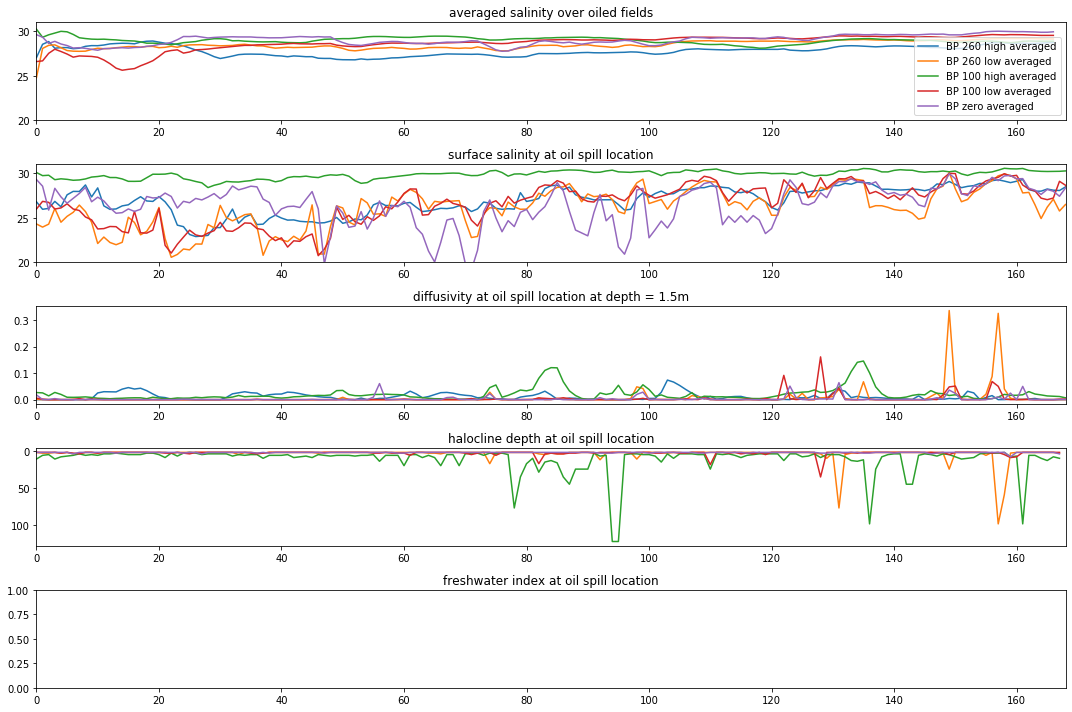

In [37]:
fig, ax = plt.subplots(5, 1, figsize = (15,10))
ax[0].plot(BP350highsal, label = 'BP 260 high averaged')
ax[0].plot(BP350lowsal, label = 'BP 260 low averaged')
ax[0].plot(BP150highsal, label = 'BP 100 high averaged')
ax[0].plot(BP150lowsal, label = 'BP 100 low averaged')
ax[0].plot(BPzerosal, label = 'BP zero averaged')
ax[0].legend()
ax[0].set_title('averaged salinity over oiled fields')
ax[0].set_ylim(20,31);

ax[1].plot(BPs0, label = 'SOG 350 high')
ax[1].plot(BPs1,label = 'SOG 350 low')
ax[1].plot(BPs2,  label = 'SOG 150 high')
ax[1].plot(BPs3, label = 'SOG 150 low')
ax[1].plot(BPs4, label = 'SOG zero')
ax[1].set_title('surface salinity at oil spill location')
ax[1].set_ylim(20,31);

ax[2].plot(BPd0, label = 'SOG 350 high')
ax[2].plot(BPd1,label = 'SOG 350 low')
ax[2].plot(BPd2,  label = 'SOG 150 high')
ax[2].plot(BPd3, label = 'SOG 150 low')
ax[2].plot(BPd4, label = 'SOG zero')
ax[2].set_title('diffusivity at oil spill location at depth = 1.5m')

ax[3].plot(BPh0)
ax[3].plot(BPh1)
ax[3].plot(BPh2)
ax[3].plot(BPh3)
ax[3].plot(BPh4)
ax[3].invert_yaxis()
ax[3].set_title('halocline depth at oil spill location')

ax[4].set_title('freshwater index at oil spill location')

for a in ax:
    a.set_xlim(0,168)
plt.tight_layout()